In [77]:
from numpy import *
import h5py
import scipy.optimize as opt
from scipy.special import factorial, gamma, gammaincc, erf
from scipy import pi
import glob

import matplotlib.pyplot as plt

In [89]:
def load_data(h5file,source,iteration,measurements,shots):
    if source == 'Hamamatsu':
        roi = array([range(4,7),range(3,6)])
        imdat = zeros((measurements,shots,len(roi[0,:]),len(roi[1,:])),dtype=int)
        for ms in range(measurements):
            for sht in range(shots):
                datpath = '/experiments/0/iterations/{}/measurements/{}/data/Hamamatsu/shots/{}'.format(iteration,ms,sht)
                #print filepath
                try:
                    im = array(h5file[(datpath)])
                    #fig,ax = plt.subplots(1,1)
                    #ax.imshow(mesDat)
                    #print mesDat[roi[0],:][:,roi[1]]
                    imdat[ms,sht,:,:] = im[roi[0],:][:,roi[1]]
                    #print ("mesDatarr",mesDatarr[it,ms,sht,:,:])
                except KeyError as e:
                    print "Error while loading data : {}".format(e)
                    print datpath
        histdat = imdat.sum(2).sum(2)
    else:
        histdat = None
    return histdat

def loading(self,fit_cut=True,zer_cut=-1,mult_cut=-1):
    if fit_cut:
        self.fit_hist()
    else: 
        try:
            #assert (zer_cut > 0 && mult_cut > 0), "If you want me to take your cuts you have to give me cuts!"
            self.zer_cut = zer_cut
            self.mult_cut = mult_cut
        except AssertionError as e:
            raise Warning(e)
            self.fit_hist()
    shot = 0
    count = self.histdat[:,shot]
    self.load_frac = (count*(count<=self.mult_cut)>=self.zer_cut).sum()*1.0/(1.0*self.measurements)
    self.no_load = (count<self.zer_cut).sum()*1.0/(1.0*measurements)
    self.mult_load = (count>self.mult_cut).sum()*1.0/(1.0*measurements)

    return self.load_frac,self.no_load,self.mult_load

def ret(histdat,cut,cuterr,popt):
    rload = (histdat[:,0]>=cut).sum()/(len(histdat[:,0])*1.0)
    print rload
    if rload > 0:
        retention = (1.0*(histdat[:,0]>=cut)*(histdat[:,1]>cut)).sum()/(histdat[:,0]>=cut).sum()
        shot_error = sqrt(retention*(1-retention)/(histdat[:,0]>=cut).sum())
        ct_error_plus = abs(1.0*((histdat[:,0]>=cut+cuterr)*(histdat[:,1]>cut+cuterr)).sum()/(histdat[:,0]>=cut+cuterr).sum()-retention)
        ct_error_minus = abs(1.0*((histdat[:,0]>=cut-cuterr)*(histdat[:,1]>cut-cuterr)).sum()/(histdat[:,0]>=cut-cuterr).sum()-retention)
        ovlp_error = get_overlap_error(cut,*abs(popt[:4]))
        print ct_error_plus,ct_error_minus
        retention_error = sqrt(shot_error**2+(ct_error_plus+ct_error_minus)**2*0.25+ovlp_error**2)
    else:
        retention = 0
        retention_error = 0
    return retention,retention_error

def fit_hist(histdat,guess=None):
    func = dblGauss

    #hdat = HmCountDat[it,:,1]
    bns = range(min(histdat),max(histdat),(max(histdat)-min(histdat))/30)
    h = histogram(histdat,bins=bns)#,normed=True)
    xdat = array(h[1][1:],dtype=float)
    ydat = array(h[0],dtype=float)

    if guess is None:
        x0g = 21000
        x1g = 24000
        std0g = 1000.0
        std1g = 2000.0
        a0g = 6.0e1
        a1g = 6.0e1
        guess = [x0g,x1g,std0g,std1g,a0g,a1g]

    popt,pcov = opt.curve_fit(f=func,xdata=xdat,ydata=ydat,p0=guess)
    perr = sqrt(diag(pcov))

    return popt,perr

def dblGauss(x,x0,x1,std0,std1,a0,a1):
    xp0 = x-x0
    xp1 = x-x1
    g0 = a0*exp(-0.5*(xp0/std0)**2)
    g1 = a1*exp(-0.5*(xp1/std1)**2)
    return g0+g1

def get_overlap_error(xc,x0,x1,s0,s1):
    return 0.5*( 1-erf((xc-x0)/(sqrt(2)*s0)) + 1-erf((x1-xc)/(sqrt(2)*s1)) )

def get_cut(x0,x1,s0,s1):
    rad = (x0-x1)**2+2*(s1**2-s0**2)*log(s1/s0)
    num = x1*s0**2-x0*s1**2-s0*s1*sqrt(rad)
    denuminv = 1/(s0**2-s1**2)
    xc = num*denuminv

    print "rad {}".format(rad)
    print "num {}".format(num)
    print "denuminv {}".format(denuminv)
    #self.zer_cut = num*denuminv
    return num*denuminv        

def get_cut_err(x0,x1,s0,s1,dx0,dx1,ds0,ds1):
    rad = (x0-x1)**2+2*(s1**2-s0**2)*log(s1/s0)
    num = x1*s0**2-x0*s1**2-s0*s1*sqrt(rad)
    rdinv = 1/sqrt(rad)
    denuminv = 1/(s0**2-s1**2)
    xc = num*denuminv

    px0 = -denuminv*(s1**2+s0*s1*rdinv*(x0-x1))
    px1 = denuminv*(s0**2+s0*s1*rdinv*(x0-x1))
    ps0 = denuminv*s0*(2*(x1-xc)-s1*sqrt(rad)/s0+s1*(s1**2/s0+s0*(2*log(s1/s0)+1)))/sqrt(rad)
    ps1 = denuminv*s1*(2*(xc-x0)-s0*sqrt(rad)/s1+s0*(s0**2/s1-s1*(2*log(s1/s0)+1)))/sqrt(rad)

    return dx0*px0+dx1*px1+ds0*ps0+ds1*ps1

In [40]:
#Path to hdf5 file, change for cspy
filepath = 'C:/Users/Juan/Repos/2019_12_12_11_45_01_LoadingBL/results.hdf5'
h5filename = filepath
print h5filename
h5file = h5py.File(h5filename)

shots = 2
measurements = h5file['settings/experiment/measurementsPerIteration'][()]
iterations = len(h5file['/iterations/'].items())
iteration = 0#self.experiment.iteration

histdat = load_data(h5file,'Hamamatsu',iteration,measurements,shots)

C:/Users/Juan/Repos/2019_12_12_11_45_01_LoadingBL/results.hdf5


rad 58281366.3436
num -68394354188.7
denuminv -3.36821115997e-07


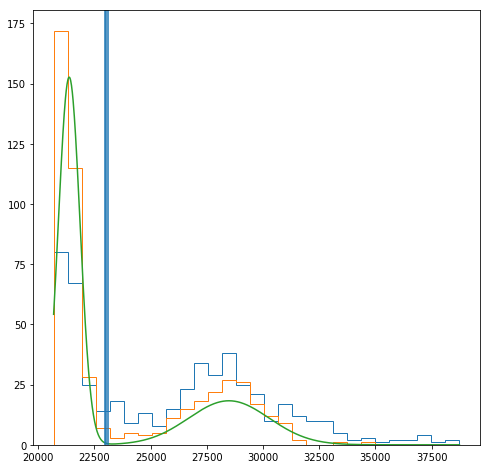

In [90]:
popt,perr = fit_hist(histdat[:,1])
cut = get_cut(*abs(popt[:4]))
cut_err = get_cut_err(*append(abs(popt[:4]),perr[:4]))
bns = linspace(min(histdat[:,1])-100,max(histdat[:,0])+100,30)
xlin = linspace(min(histdat[:,1])-100,max(histdat[:,0])+100,1000)
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.hist(histdat[:,0],histtype="step",bins=bns,label="Shot 0")
ax.hist(histdat[:,1],histtype="step",bins=bns,label="Shot 1")
ax.plot(xlin,dblGauss(xlin,*popt))
ax.axvline(x=cut)
ax.axvline(x=cut+cut_err)
ax.axvline(x=cut-cut_err)
#ax.set_xlim(22900,23100)
fig.show()

In [88]:
retention,retention_error = ret(histdat,cut,cut_err,popt)
print retention,retention_error
print get_overlap_error(cut,*abs(popt[:4]))

0.632
0.0031645569620253333 0.0036024201894754304
0.5727848101265823 0.028069908502681373
0.0014481627400753094


In [75]:
xlin = linspace(0,50,1000)
x0 = 10.0
x1 = 30.0
s0 = sqrt(x0)
s1 = sqrt(x1)
a0 = 0.5
a1 = 0.5
g = OPTcosts.dblGauss(xlin,x0,x1,s0,s1,a0,a1)
popt,perr = OPTcosts.fit_hist(xlin,g,x0,x1)
c = OPTcosts.get_cut(x0,x1,s0,s1)
fig,ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(xlin,g)
ax.plot(xlin,OPTcosts.dblGauss(xlin,*popt))
ax.axvline(x=c)
fig.show()
print c


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

In [73]:
print popt

[21000. 24000.  1000.  2000.    60.    60.]


In [18]:
help(OPTcosts.get_cut)

Help on function get_cut in module __main__:

get_cut(x0, x1, s0, s1)



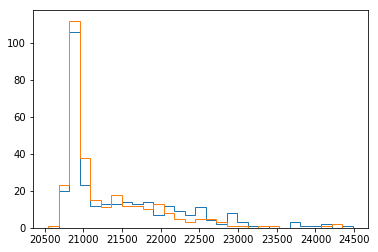

In [54]:
plt.hist(cst.histdat[:,0],histtype="step",bins=cst.bns,label="Shot 0")
plt.hist(cst.histdat[:,1],histtype="step",bins=cst.bns,label="Shot 1")
plt.show()

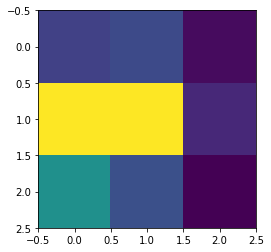

In [56]:
plt.imshow(cst.imdat[:,0,:,:].mean(0))

In [67]:
f = 5
try:
    assert f==6, "Bruh"
except AssertionError as e:
    raise Warning(e)

Warning: Bruh